### **Esse Processo de Avaliação de imagem foi realizado pensando na seguinte situação Hipotética.**

Suponha que temos 1 imagem, porém essa imagem passou pelo processo de redução de tamanho/diminuição de sua resolução. Por algum motivo o arquivo original da imagem foi perdido ou não pode ser utilizado. Surge a necessidade de, a partir da imagem de menor resolução, obtermos uma versão com resolução e qualidade similar a original. Nesse contexto temos:

**Imagem Original** - 500 pixels de altura e 500 pixels de largura (500x500)

**Imagem de menor resolução** - 150 pixels de altura e 150 pixels de largura (150x150)

Para resolver tal problema a partir da imagem menor resolução será realizado o processo de super-resolution utilizando o modelo de inteligência artificial SRGAN. Gerando uma versão com maior resolução a partir desta imagem de baixa resolução.

Após esse processo vamos forçar com que o arquivo da imagem de menor resolução e sua versão que passou pelo processo de super-resolution tenham a mesma resolução da imagem original (500x500), para assim compararmos utilizando métodos objetivos as duas versões com a imagem original e vermos como cada imagem vai ser avaliada. Permitindo a conclusão se o processo de super-resolution se mostrou eficaz.

Os dois métodos utilizados avaliam as imagens de maneiras diferentes.

1. PSNR avalia a qualidade de uma imagem a partir do calculo da razão entre o maior valor possível do sinal que a imagem pode emitir e o sinal de ruído que a mesma emite, quanto maior o resultado melhor é a qualidade da imagem.

2. SSIM vai avaliar principalmente o quão similiar a imagem referência e a imagem processada são, utilizando de informações de luminância, contrast e estrutura. Quanto mais próximo de 1 mais similares são as imagens quanto mais próximos de -1 menos similares são.

In [ ]:
import time
import cv2
from cv2 import dnn_superres
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.color import rgb2ycbcr
from google.colab import files
from PIL import Image

In [ ]:
!pip install psnr_hvsm
from psnr_hvsm import psnr_hvs_hvsm
from psnr_hvsm import bt601ycbcr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 24.2 MB/s eta 0:00:00
PyTorch not installed, if you wish to use PyTorch, install as psnr_hvsm[torch]:
$> pip install psnr_hvsm[torch]


### 1. **Agora vamos difinir as 2 funções que vamos utilizar para avaliar as imagens**

   * Primeiro definimos a função que utiliza o **Peak Signal To Noise Ratio**


In [ ]:
def PSNR(original_img, new_img):
  psnr_low = psnr(original_img, new_img)
  print("PSNR da imagem em comparação com a original é: ", psnr_low)
  return psnr_low

In [ ]:
def PSNR_HVS(original_img, new_img):
  psnr_low = psnr_hvs_hvsm(original_img, new_img)
  print("PSNR da imagem em comparação com a original é: ", psnr_low)

  * Agora definimos a função que utiliza **Structural Similarity**

In [ ]:
def SSIM(original, new_img):
  low_quality = ssim(original, new_img, win_size=3)
  print("SSIM da imagem em comparação com a original é: ", low_quality)
  return low_quality

### 2. **Agora precisamos definir e armazenar 3 imagens diferentes**
* A imagem original de referência (500x500)
* Imagem original de baixa Resolução (150x150)
* Imagem de baixa resolução que passou pelo processso de super Resolution

### 3. **Acessamos o drive para podermos salvar as imagens utilizadas**

*Importante pontuar que o usuário ao executar a célula a seguir vai estar dando permissão ao sistema colab para acessar seu banco de dados Google Drive, vale citar que tanto o colab quanto o google drive são softwares da mesma empresa (google)*

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### 4. **salvamos nossa imagem original que vai servir como método de comparação com as outras duas imagens**

* Primeiro definimos o local onde vamos salvar nossa imagem original.

  **O local em questão pode ser Qualquer pasta dentro do drive que o usuário desejar**

In [ ]:
local_to_img = "/content/drive/MyDrive/TCC/Texto_Principal/Analise_De_Resultados/Imagens"

* Função que salva a imagem

In [ ]:
def upload_original():
  original_img = files.upload()
  if original_img is not None:
    for filename in original_img.keys():
      with open(os.path.join(local_to_img, filename), "wb") as f:
        f.write(original_img[filename])
      pilImage = Image.open(filename).convert("RGB")
      TransformCv = np.array(pilImage)[:, :, ::-1].copy()
  return pilImage

original = upload_original()

Saving objeto.jpg to objeto.jpg


### 5. **Com a imagem devidamente recuperada, criamos funções para redução do tamanho da imagem para o tamanho estabelecido no nosso contexto.**

* Funções para diminui a resolução da imagem que importamos

In [ ]:
def resize_image150x150(original_image):
  return original_image.resize((150, 150), Image.LANCZOS)

* Função que transforma imagem PIL em um array

In [ ]:
def cv2_transform(image):
  return np.array(image)[:, :, ::-1].copy()

### 6. **Com as funções necessárias definidas, podemos a partir da nossa imagem original(referência), gerar nossa imagem de baixa resolução**

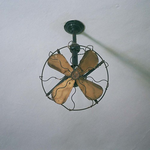

In [ ]:
img150x150 = resize_image150x150(original)
img150x150

 ### 7. **Agora com as funções necessárias definidas precisamos importar as funções para utilização do modelo SRGAN e fazer o uspcaling da imagem em questão.**
 Caso presente leitor já tenha testado o outro arquivo colab elaborado pelo autor que também utiliza o modelo SRGAN, vai reparar que estamos apenas importanto os mesmos arquivos do modelo para utiliza-lo em outro contexto.

Explicando de maneira breve:

1. Acessamos/importamos o diretório onde está nossos arquivos do modelo e de funções necessárias para sua utilização;

2. Atribuimos ao modelo os pesos já pré-treinados;

3. Definimos nossa função que utiliza o modelo já carregado com os pesos pré-treinados

In [ ]:
sys.path.append("/content/drive/MyDrive/SrganNoColab/super-resolution-colab")

from data import DIV2K
from model.srgan import generator

In [ ]:
diretoriosPesos = "/content/drive/MyDrive/SrganNoColab/super-resolution-colab/weights/srgan/weights/srgan"
arquivoPesos = lambda filename: os.path.join(diretoriosPesos, filename)

os.makedirs(diretoriosPesos, exist_ok=True)

In [ ]:
gan_generator = generator()

gan_generator.load_weights(arquivoPesos("gan_generator.h5"))

In [ ]:
from utils import load_image
from model import resolve_single

def upscaling_visualizacao(lr_image):
  lr = cv2_transform(lr_image)
  gan_upscaling = resolve_single(gan_generator, lr)
  return gan_upscaling

### 8. **Aqui Estamos Efetivamente fazendo o upscaling da nossa imagem de tamanho 150x150**

In [ ]:
srImagem = upscaling_visualizacao(img150x150)

### **9. Fazemos um processo de conversão para o formato RGB original da imagem, garantindo que a imagem terá paleta de cores igual a original.**

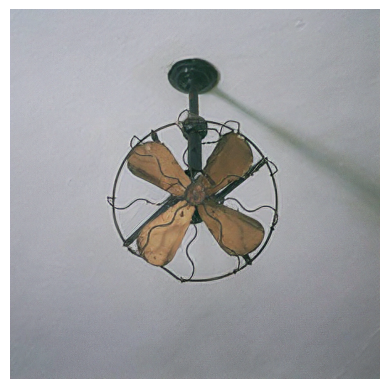

In [ ]:
img = srImagem.numpy().astype(np.uint8)
# retornando imagens para paleta original
b,g,r = cv2.split(img)
srImagem = cv2.merge([r,g,b])
plt.axis("off")
plt.gca().set_axis_off()
plt.imshow(srImagem)
plt.savefig('srImagem.png', bbox_inches='tight')
# plt.show(srImagem)

array([[[179, 174, 191],
        [183, 181, 192],
        [172, 180, 187],
        ...,
        [137, 145, 154],
        [145, 154, 155],
        [144, 149, 156]],

       [[172, 176, 194],
        [177, 184, 194],
        [171, 174, 187],
        ...,
        [142, 149, 157],
        [146, 154, 162],
        [142, 148, 156]],

       [[173, 176, 192],
        [174, 183, 189],
        [175, 182, 190],
        ...,
        [144, 155, 160],
        [144, 150, 160],
        [142, 142, 153]],

       ...,

       [[135, 130, 140],
        [135, 139, 138],
        [133, 133, 141],
        ...,
        [107, 114, 116],
        [108, 113, 114],
        [107, 113, 104]],

       [[138, 128, 141],
        [136, 129, 141],
        [133, 134, 142],
        ...,
        [106, 115, 114],
        [108, 116, 114],
        [116, 116, 113]],

       [[136, 129, 142],
        [136, 125, 142],
        [126, 125, 139],
        ...,
        [101, 110, 110],
        [102, 106, 110],
        [117, 122, 115]]], dtype=uint8)
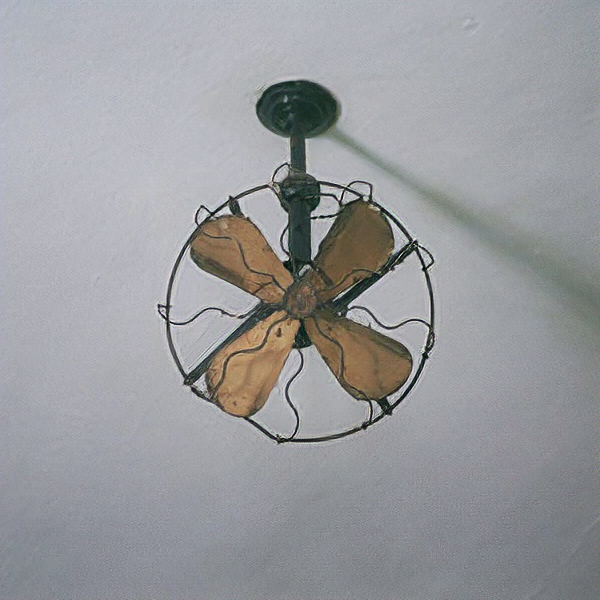

In [ ]:
srImagem

### 10. **Com as imagens de baixa resolução e a imagem de alta resolução podemos então avaliar o resultado do processo de de super-resolution e comparar a imagem de baixa resolução com a imagem de maior resolução gerada a partir desta.**

* Obtemos as informações de altura e largura da imagem que passou pelo super-resolution

In [ ]:
SRheight, SRwidth, channels = srImagem.shape

In [ ]:
Lowheight, Lowwidth = img150x150.size

* Criamos a função para podermos visualizar o gráfico comparativo

In [ ]:
def create_plot_res(srheight, srwidth, lowheight, Lowwidth):
  values = [srheight, srwidth, lowheight, Lowwidth]
  labels = ['Altura imagem SRGAN', 'largura imagem SRGAN', 'Altura imagem baixa resolução', 'Largura Imagem baixa resolução']
  colors = plt.bar([1, 2, 3, 4], values)
  plt.xticks([1, 2, 3, 4], labels, rotation=90)  # Rotate labels if needed
  colors[0].set_color('red')
  colors[1].set_color('red')
  colors[2].set_color('blue')
  colors[3].set_color('blue')
  plt.ylabel('Valor em pixels')
  plt.title('Comparação da diferença de resolução entre as imagens')

* Executamos a função passando os dados como parâmetro

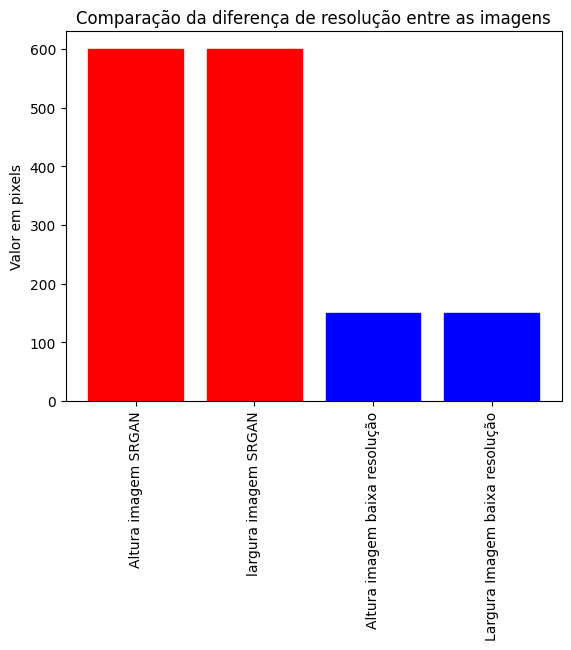

In [ ]:
create_plot_res(SRheight, SRwidth, Lowheight, Lowwidth)

### 11. **Agora é necessário que tanto nossa imagem de baixa resolução quanto nossa imagem que passou pelo processo de super-resultion tenham o mesmo tamanho e estejam em um formato específico para que possamos compara-las. Fazemos então mais uma vez a transformação da imagem.**


* Imagem que passou pelo processo de super-resolution, com tamanho aumentado para (500x500)

array([[[179, 175, 191],
        [179, 181, 190],
        [173, 183, 190],
        ...,
        [136, 145, 152],
        [143, 151, 155],
        [144, 149, 156]],

       [[173, 177, 193],
        [175, 181, 191],
        [173, 179, 190],
        ...,
        [143, 152, 158],
        [144, 152, 160],
        [142, 147, 156]],

       [[173, 177, 191],
        [173, 182, 188],
        [174, 182, 190],
        ...,
        [143, 152, 157],
        [144, 151, 159],
        [145, 145, 156]],

       ...,

       [[134, 130, 141],
        [134, 137, 141],
        [133, 136, 142],
        ...,
        [108, 115, 117],
        [107, 113, 115],
        [109, 116, 109]],

       [[137, 129, 140],
        [135, 132, 140],
        [133, 134, 143],
        ...,
        [105, 113, 114],
        [107, 115, 114],
        [113, 115, 110]],

       [[136, 128, 142],
        [133, 125, 141],
        [125, 126, 139],
        ...,
        [103, 112, 113],
        [102, 108, 110],
        [115, 120, 114]]], dtype=uint8)
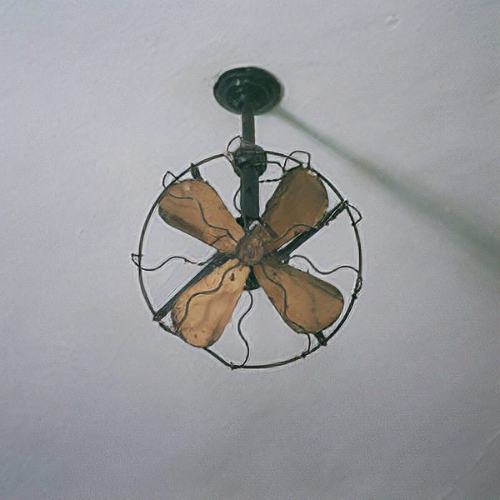

In [ ]:
srImagem600x600 = srImagem
srImagem = cv2.resize(srImagem, (500, 500), Image.LANCZOS)
srImagem

* Imagem de baixa resolução com tamanho aumentado para (500x500)

array([[[178, 186, 199],
        [178, 186, 199],
        [178, 186, 199],
        ...,
        [146, 155, 163],
        [146, 155, 164],
        [146, 155, 164]],

       [[178, 186, 199],
        [178, 186, 199],
        [178, 186, 199],
        ...,
        [146, 155, 163],
        [146, 155, 164],
        [146, 155, 164]],

       [[178, 186, 199],
        [178, 186, 199],
        [178, 186, 199],
        ...,
        [147, 156, 163],
        [147, 156, 164],
        [147, 156, 164]],

       ...,

       [[132, 137, 145],
        [132, 137, 145],
        [132, 137, 145],
        ...,
        [105, 116, 117],
        [105, 116, 117],
        [105, 116, 117]],

       [[134, 137, 146],
        [134, 137, 146],
        [134, 137, 146],
        ...,
        [105, 117, 117],
        [105, 117, 117],
        [105, 117, 117]],

       [[134, 137, 146],
        [134, 137, 146],
        [134, 137, 146],
        ...,
        [105, 117, 117],
        [105, 117, 117],
        [105, 117, 117]]], dtype=uint8)
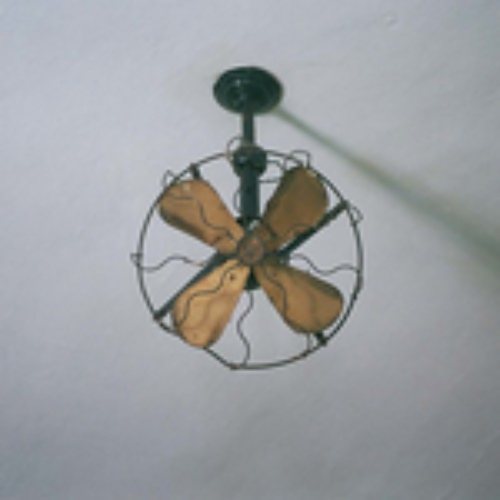

In [ ]:
img150x150 = np.array(img150x150)
img150low = img150x150
img150x150 = cv2.resize(img150x150, (500, 500), Image.LANCZOS)
img150x150

* Imagem original

array([[[180, 188, 201],
        [177, 185, 198],
        [178, 186, 199],
        ...,
        [148, 157, 166],
        [145, 154, 163],
        [143, 152, 161]],

       [[177, 185, 198],
        [178, 186, 199],
        [179, 187, 200],
        ...,
        [147, 156, 165],
        [145, 154, 163],
        [144, 153, 162]],

       [[176, 184, 197],
        [178, 186, 199],
        [178, 186, 199],
        ...,
        [146, 155, 162],
        [145, 154, 161],
        [146, 155, 162]],

       ...,

       [[132, 136, 145],
        [131, 135, 144],
        [132, 136, 145],
        ...,
        [103, 115, 115],
        [103, 115, 115],
        [105, 117, 117]],

       [[136, 140, 149],
        [134, 138, 147],
        [134, 138, 147],
        ...,
        [104, 116, 116],
        [104, 116, 116],
        [107, 119, 119]],

       [[136, 140, 149],
        [135, 139, 148],
        [135, 139, 148],
        ...,
        [107, 119, 119],
        [107, 119, 119],
        [107, 119, 119]]], dtype=uint8)
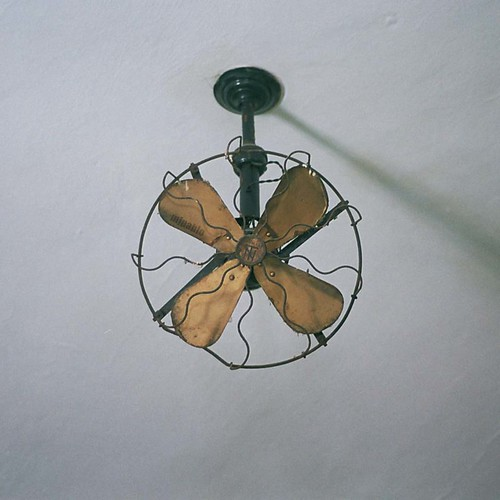

In [ ]:
original = np.array(original)
original

* Calculo do PSNR

In [ ]:
PSNR_Srgan = PSNR(original, srImagem)
PSNR_baixa_Res = PSNR(original, img150x150)

PSNR da imagem em comparação com a original é:  30.022694736227056
PSNR da imagem em comparação com a original é:  27.81292678727904


In [ ]:
SSIM_Srgan = SSIM(original, srImagem)
SSIM_Baixa_Res = SSIM(original, img150x150)

SSIM da imagem em comparação com a original é:  0.8805257268720929
SSIM da imagem em comparação com a original é:  0.9244078493406045


### **12. Agora Criamos as funções para visualização gráfica da diferença entre os resultados**

* Gráfico PSNR

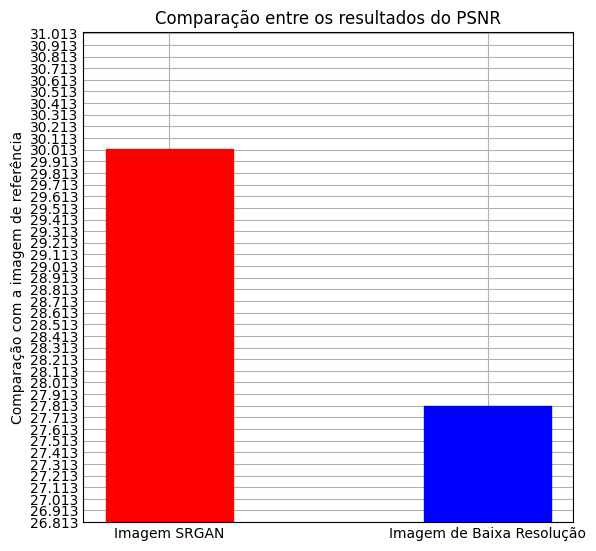

<Figure size 200x200 with 0 Axes>

In [ ]:
def create_plot_psnr(srgan, lowRes):
  values = [srgan, lowRes]
  min_value = min(values)
  max_value = max(values)

  plt.style.use('_mpl-gallery')
  fig, ax = plt.subplots(figsize=(5, 5))
  colors = plt.bar([1, 3], values)
  colors[0].set_color('red')
  colors[1].set_color('blue')
  plt.xticks([1, 3], ['Imagem SRGAN', 'Imagem de Baixa Resolução'])
  plt.yticks(np.arange(min_value - 1, max_value + 1, 0.1))
  plt.ylabel('Comparação com a imagem de referência')
  plt.title('Comparação entre os resultados do PSNR')
  plt.ylim(min_value - 1, max_value + 1)
  plt.show()
  plt.savefig('PSNR.png', dpi=100.0)

create_plot_psnr(PSNR_Srgan, PSNR_baixa_Res)

* Gráfico SSIM

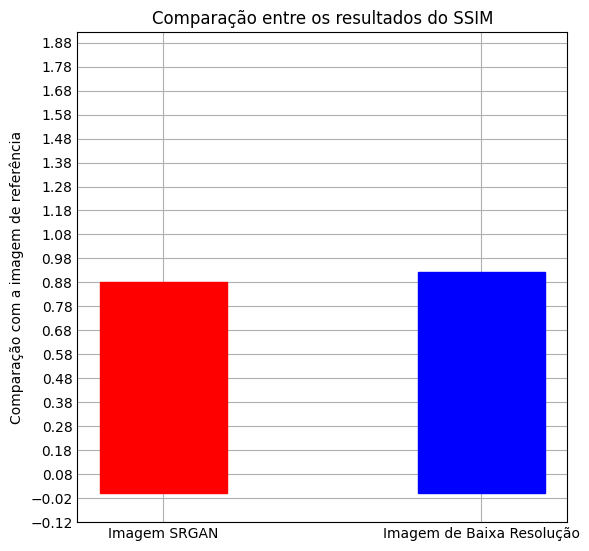

<Figure size 200x200 with 0 Axes>

In [ ]:
def create_plot_ssim(srgan, lowRes):
  values = [srgan, lowRes]
  min_value = min(values)
  max_value = max(values)

  plt.style.use('_mpl-gallery')
  fig, ax = plt.subplots(figsize=(5, 5))
  colors = plt.bar([1, 3], values)
  colors[0].set_color('red')
  colors[1].set_color('blue')
  plt.xticks([1, 3], ['Imagem SRGAN', 'Imagem de Baixa Resolução'])
  plt.yticks(np.arange(min_value - 1, max_value + 1, 0.1))
  plt.ylabel('Comparação com a imagem de referência')
  plt.title('Comparação entre os resultados do SSIM')
  plt.ylim(min_value - 1, max_value + 1)
  plt.show()
  plt.savefig('SSIM.png', dpi=100.0)

create_plot_ssim(SSIM_Srgan, SSIM_Baixa_Res)

### **13. Resumo de todas as imagens geradas no processo de analise**

Com a avaliação completa, abaixo temos um resumo de todas as imagens utilizadas.

Todas as imagens foram aumentadas para um tamanho única para facilitar a visualização

In [ ]:
images = [original, srImagem, srImagem600x600, img150x150, img150low]
titles = ["Imagem original", "Imagem gerada pelo SRGAN 600x600", "Imagem SRGAN 500x500",  "Imagem de baixa resolução aumentada para 500x500", "imagem de baixa resolução 150x150" ]


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,12))

for i, ax in enumerate(axes.flat):
  if i < len(images):
    ax.imshow(images[i])
    ax.set_title(titles[i])
    ax.axis('off')

axes.flat[-1].axis('off')

plt.tight_layout()
plt.show()